In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tes_analysis_tools as tat
import sklearn
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.distribution import MultiprocessingDistributor
sns.set()

In [63]:
dir = "../WF/exp1/"
savedir = "./exp1_result/"
pulse = np.load(dir + "pulse.npy")
noise = np.load(dir + "noise.npy")
time  = np.load(dir + "time.npy")

n  = pulse.shape[0]
dp = pulse.shape[1]
m  = noise.shape[0]
dt = time[1] - time[0]

In [64]:
# baseline 補正, 先頭からdpbl点の平均をoffsetとして引き去る
dpbl = 200
pulse = tat.correct_baseline(pulse, dpbl)

# 正負反転
pulse = -1.0 * pulse

In [65]:
df = pd.DataFrame(pulse)
df.index.name = "id"

# データ補正

In [66]:
def regression(data):
    fit = np.polyfit(time, data, 18)
    fit_fn = np.poly1d(fit)
    return fit_fn(time)

def plot_regression_curve(x, y, n=18):
    fit = np.polyfit(x, y, n)
    fit_fn = np.poly1d(fit)
    plt.plot(x, y, label="data")
    plt.plot(x, fit_fn(x), label="regression")
    plt.legend()
    plt.show()

In [67]:
df_corrected = df.apply(regression, axis=1, result_type="expand")
pulse = df_corrected.values

# 主成分分析

(10000, 2)


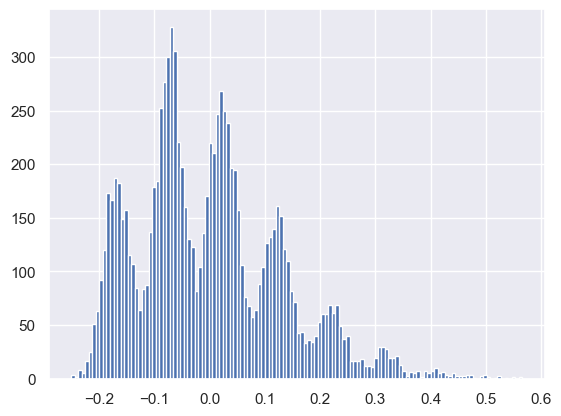

In [68]:
# 主成分分析
pca = PCA(n_components=2)
pca.fit(pulse)
X_pca = pca.transform(pulse)
print(X_pca.shape)
# 第一主成分のヒストグラム
plt.hist(X_pca[:, 0], bins=128)
plt.show()

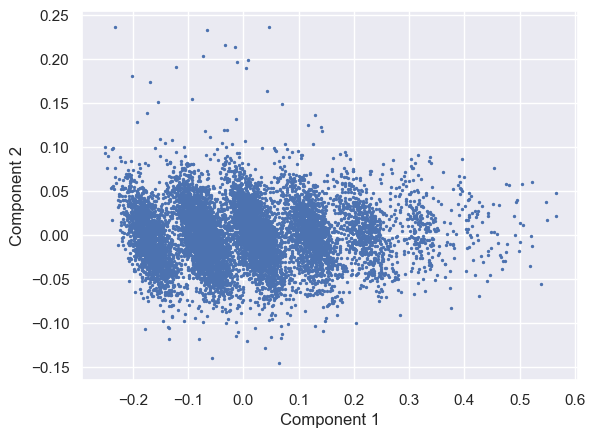

In [69]:
# 第一, 第二主成分の散布図 <- これをクラスタリングしたい
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=2)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

## K-Means

In [70]:
def plot_clusters(X, cluster_ids, cluster_id_range):
    for class_value in cluster_id_range:
        row_ix = np.where(cluster_ids == class_value)
        plt.scatter(X[row_ix, 0], X[row_ix, 1], s=1)
    plt.show()

c:\Users\keisu\UTokyo\RyoikiProject\PhotonClustering\photon_clustering_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Counter({0: 2961, 2: 2651, 3: 1809, 1: 1535, 5: 734, 4: 310})


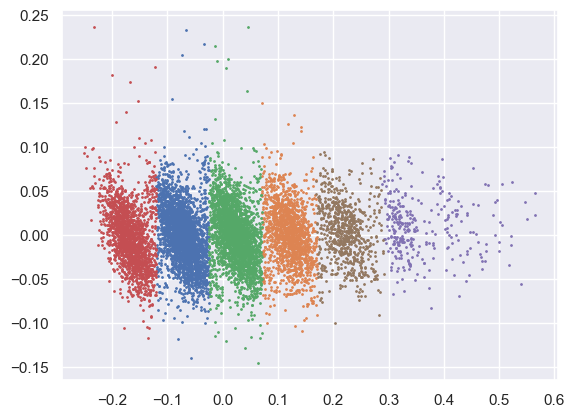

In [71]:
kmeans_model = KMeans(n_clusters=6)
kmeans_model.fit(X_pca)
yhat = kmeans_model.predict(X_pca)
print(Counter(yhat))
plot_clusters(X_pca, yhat, list(set(yhat)))

## DBSCAN

Counter({3: 2804, 0: 2463, -1: 1903, 1: 1517, 2: 1148, 4: 165})


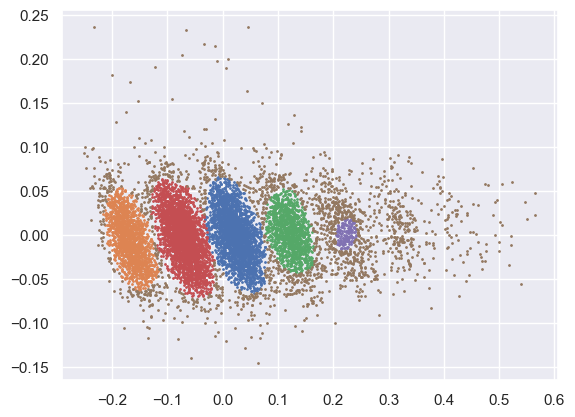

In [72]:
dbscan_model = DBSCAN(eps=0.014, min_samples=100)
yhat = dbscan_model.fit(X_pca)
print(Counter(yhat.labels_))
plot_clusters(X_pca, yhat.labels_, list(set(yhat.labels_)))

# tsfresh

In [73]:
# tsfreshに対応した形に変換
df_tsfresh = df_corrected.stack().reset_index()
df_tsfresh.columns = ["id", "time", "voltage"]
df_tsfresh["id"] = df_tsfresh["id"].astype("object")
df_tsfresh["time"] = df_tsfresh["time"].astype("object")

# tsfreshによる特徴量作成
Distributor = MultiprocessingDistributor(n_workers=os.cpu_count(), disable_progressbar=False, progressbar_title="Feature Extraction")
extracted_features = extract_features(df_tsfresh, column_id="id", column_sort="time", distributor=Distributor)
impute(extracted_features)

Feature Extraction: 100%|██████████| 60/60 [16:56<00:00, 16.95s/it]  
c:\Users\keisu\UTokyo\RyoikiProject\PhotonClustering\photon_clustering_env\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['voltage__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,voltage__variance_larger_than_standard_deviation,voltage__has_duplicate_max,voltage__has_duplicate_min,voltage__has_duplicate,voltage__sum_values,voltage__abs_energy,voltage__mean_abs_change,voltage__mean_change,voltage__mean_second_derivative_central,voltage__median,...,voltage__fourier_entropy__bins_5,voltage__fourier_entropy__bins_10,voltage__fourier_entropy__bins_100,voltage__permutation_entropy__dimension_3__tau_1,voltage__permutation_entropy__dimension_4__tau_1,voltage__permutation_entropy__dimension_5__tau_1,voltage__permutation_entropy__dimension_6__tau_1,voltage__permutation_entropy__dimension_7__tau_1,voltage__query_similarity_count__query_None__threshold_0.0,voltage__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,2.431407,0.045409,0.000103,-8.436334e-06,-5.803872e-07,0.000391,...,0.136002,0.136002,0.181214,0.777735,0.865515,0.953206,1.040802,1.126253,0.0,0.022084
1,0.0,0.0,0.0,0.0,-0.014668,0.001328,0.000041,-7.821863e-06,-6.724199e-07,0.000125,...,0.090729,0.136002,0.181214,0.768789,0.849258,0.929649,1.009960,1.090185,0.0,0.003774
2,0.0,0.0,0.0,0.0,-0.217483,0.002105,0.000044,2.093659e-06,7.445742e-07,0.000031,...,0.136002,0.136002,0.181214,0.775334,0.862738,0.950050,1.037265,1.126637,0.0,0.003157
3,0.0,0.0,0.0,0.0,3.654663,0.079010,0.000088,1.888025e-06,-4.071741e-07,0.000405,...,0.125256,0.136002,0.136002,0.757550,0.832158,0.906736,0.981280,1.055787,0.0,0.027354
4,0.0,0.0,0.0,0.0,-0.959004,0.003903,0.000045,-9.048918e-07,-2.331180e-07,-0.000531,...,0.136002,0.136002,0.181214,0.775533,0.858121,0.940642,1.025604,1.110496,0.0,0.005010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,1.862584,0.013776,0.000065,1.322228e-05,7.720573e-10,0.001418,...,0.125256,0.136002,0.136002,0.760924,0.832455,0.906464,0.980447,1.054400,0.0,0.010443
9996,0.0,0.0,0.0,0.0,1.475924,0.013519,0.000068,3.368865e-06,-8.746833e-07,0.000786,...,0.125256,0.125256,0.136002,0.738791,0.792257,0.845727,0.899200,0.952676,0.0,0.009951
9997,0.0,0.0,0.0,0.0,1.648666,0.060765,0.000112,1.504414e-06,-3.130006e-07,-0.001194,...,0.125256,0.125256,0.181214,0.770493,0.854257,0.939864,1.025400,1.113374,0.0,0.024331
9998,0.0,0.0,0.0,0.0,2.871660,0.045860,0.000087,-4.501316e-06,-2.421368e-07,0.000581,...,0.125256,0.136002,0.181214,0.767706,0.850011,0.932240,1.014390,1.091697,0.0,0.019284


In [74]:
# csvファイルに保存
extracted_features.to_csv("../data/tsfresh_features.csv",index=False)

In [75]:
# 2回目以降csvから読み出し
tsfresh_features = pd.read_csv("../data/tsfresh_features.csv")

In [76]:
def remove_constant_columns(df):
    df_filtered = df.loc[:, df.nunique() != 1]
    return df_filtered

def remove_binary_columns(df):
    columns_to_select = df.apply(lambda col: not set(col.unique()).issubset({0,1}))
    df_filtered = df.loc[:, columns_to_select]
    return df_filtered

def remove_constant_or_binary_columns(df):
    columns_to_select = df.apply(lambda col: (col.nunique() != 1) and not set(col.unique()).issubset({0,1}))
    df_filtered = df.loc[:, columns_to_select]
    return df_filtered

def standardize(df):
    scaler = StandardScaler()
    df_std = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return df_std

def remove_corr_cols(df, threshold=0.7):
    corr = df.corr().abs()
    high_corr = np.where(corr>threshold)
    to_drop = []
    for idx, col in zip(high_corr[0], high_corr[1]):
        f1, f2 = corr.index[idx], corr.columns[col]
        if f1 != f2 and f1 not in to_drop and f2 not in to_drop:
            to_drop.append(f1)
    df_filtered = df.drop(to_drop, axis=1)
    return df_filtered

def my_preprocess(df, threshold=0.7):
    df_filtered = remove_constant_or_binary_columns(df)
    df_filtered = standardize(df_filtered)
    df_filtered = remove_corr_cols(df_filtered,threshold)
    return df_filtered

In [77]:
features = my_preprocess(tsfresh_features)

## tsfreshの特徴量に対して主成分分析

In [78]:
tsfresh_pca = PCA(n_components=2)
X_pca_tsfresh = pca.fit_transform(features)

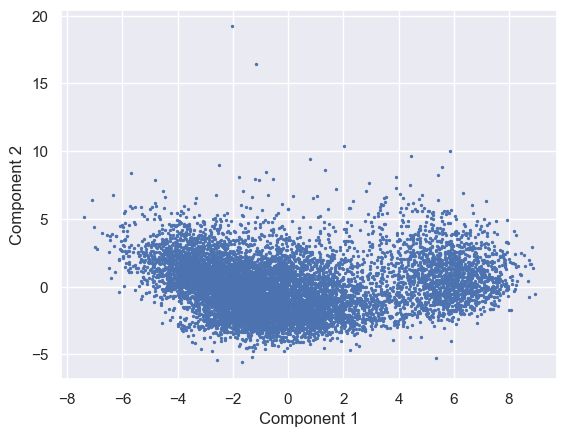

In [79]:
plt.scatter(X_pca_tsfresh[:,0], X_pca_tsfresh[:,1], s=2)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

## K-Means

c:\Users\keisu\UTokyo\RyoikiProject\PhotonClustering\photon_clustering_env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


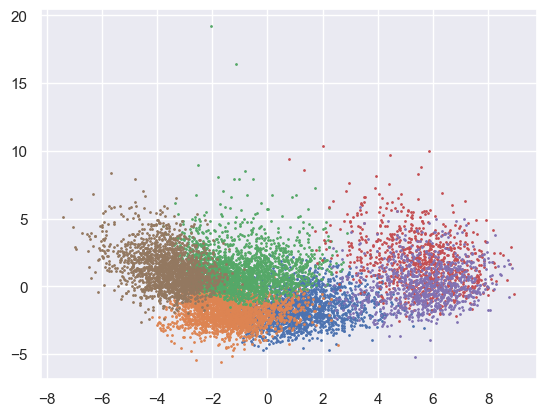

In [80]:
kmeans_model = KMeans(n_clusters=6)
kmeans_model.fit(features)
y_pred = kmeans_model.predict(features)
Counter(y_pred)
plot_clusters(X_pca_tsfresh, y_pred, list(set(y_pred)))

## DBSCAN

Counter({0: 6772, -1: 3228})


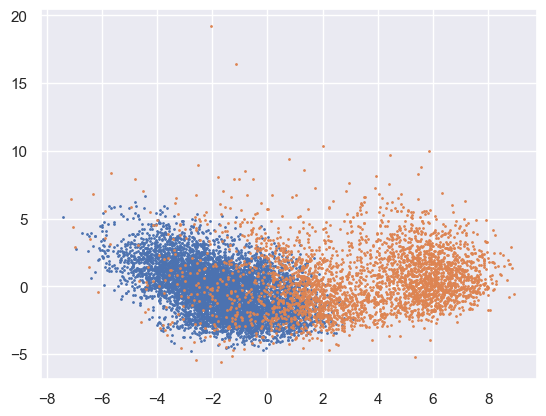

In [81]:
dbscan_model = DBSCAN(eps=6, min_samples=50)
y_pred = dbscan_model.fit(features).labels_
print(Counter(y_pred))
plot_clusters(X_pca_tsfresh, y_pred, list(set(y_pred)))